## Алгоритмы машинного обучения. Деревья решений. Случайный лес

In [3]:
# импорт библиотек

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

Для сходимости ответов у вас должен быть установлен sklearn версии 0.21.3

In [4]:
print(sklearn.__version__)

0.22.1


In [5]:
# читаем датасет

data = pd.read_csv('titanic_train.csv')

In [6]:
# небольшой препроцессинг

data['sex'] = data['sex'].map({'male': 0, 'female': 1})
data['age'] = np.trunc(data['age'])
data = data.fillna(data.median())

## Поиск порога для разбиения по числовому признаку в деревьях решений.

На практическом занятии мы вручную разбивали исходную выборку по признаку "пол" и смотрели на значение функционала качества при таком разбиении, а также на значения энтропии в двух получившихся после разбиения выборках. Признак "пол" был бинарным, поэтому у нас имелся только один возможный порог для разбиения. В случае с числовыми признаками все иначе.
Если признак числового типа, то в узле формируется правило вида $X_i <= t$. Где $t$ – некоторый порог, который чаще всего выбирается как среднее арифметическое двух соседних упорядоченных значений признака $X_i$ обучающей выборки.
Мы будем работать с признаков "возраст". Найдите с точки зрения функционала качества оптимальный порог для разбиения по этому признаку. Для этого необходимо:
- найти уникальные значения признака "возраст" в исходной выборке, упорядочить их по возрастанию;
- рассчитать средние значения между двумя сосденими элементами получившегося упорядоченного ряда (пример: для ряда [18, 19, 20, 21] результат будет [18.5, 19.5, 20.5]). Они будут являться множеством порогов для поиска;
- среди полученного множества найти тот порог, при котором достигается максимум функции $Q(X, j, t)$, где $X$ – исходная выборка, $j$ – признак ("age"), $t$ - порог, который требуется найти.

Для справки:
$$Q(X, j, t) = H(X) - \dfrac{|X_l|}{|X|} H(X_l) - \dfrac{|X_r|}{|X|} H(X_r),$$
где $X$ – выборка, находящаяся в текущей вершине, $X_l$ и $X_r$ – разбиение выборки $X$ на две части по предикату $[x_j < t]$ (то есть по $j$-ому признаку и порогу $t$), $|X|$, $|X_l|$, $|X_r|$ - размеры соответствующих выборок, а $H(X)$ – энтропия ответов на выборке $X$:
$$H(X) = - \sum_{k=0}^{N}(p_k ln p_k),$$
где $k$ – номер класса, $p_k$ – доля объектов класса $k$ в выборке $X$.

Вы можете использовать функции, которые были реализованы в начале практики.

In [7]:
# Ваш код
def Q(X, j, t):
    Xl = X[X[j] <= t]
    Xr = X[X[j] > t]
    quality = H(X) - len(Xl)/len(X)*H(Xl) - len(Xr)/len(X)*H(Xr)
    return quality

def H(X):
    p1 = len(X[X['survived'] == 0]) / len(X)
    p2 = len(X[X['survived'] == 1]) / len(X)
    ent = - (p1*np.log(p1) + p2*np.log(p2))
    return ent

In [8]:
unique_age = data['age'].unique()
unique_age.sort()
print(unique_age)

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53.
 54. 55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65. 67. 70. 74. 76. 80.]


In [9]:
for_search_t = np.zeros(unique_age.size-1)

for i in range(unique_age.size-1):
    t = (unique_age[i] + unique_age[i+1]) / 2
    for_search_t[i] = t

In [10]:
res_Q = np.zeros(for_search_t.size)

for i in range(for_search_t.size-2):
    res_Q[i] = Q(data, 'age', for_search_t[i]) 

In [11]:
opt_Q = round(res_Q.max(), 3)
opt_t = for_search_t[res_Q.argmax()]
print(opt_Q, opt_t)

0.01 9.5


**<font color='red'>Вопрос 1.</font> Каково оптимальное значение порога разбиеня по признаку "возраст" с точки зрения функционала качества?**
- 7.5
- 8.5
- 9.5
- 10.5

In [12]:
print(Q(data, 'age', 9.5))

0.009560320822106338


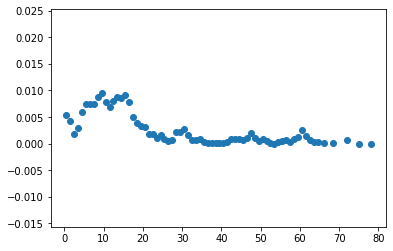

In [13]:
plt.scatter(for_search_t, res_Q)

**<font color='red'>Вопрос 2.</font> Каково значение функционала качества Q при разбиении по признаку "возраст" с полученным порогом (округлите до 3-х знаков после запятой)? Является ли такое разбиение более оптимальным по сравнению с разбиением по признаку "пол"?**
- 0.007, да
- 0.010, нет
- 0.010, да
- 0.007, нет

## Деревья решений

В этом задании мы будем работать с датасетом Сalifornia housing. Решать предстоит задачу регресси: прогнозирование цены недвижимости (признак Price).
Для оценки качества модели мы будем использовать коэффициент детерминации r2. Для подбора гиперпараметров моделей будем использовать обычную пятифолдовую кросс-валидацию.

In [14]:
data = pd.read_csv('California_housing.csv')
X = data.drop('Price', axis = 1)
y = data['Price']

Разделите выборку на обучающую и тестовую в соотношении 7:3. Зафиксируйте `random_state`=20. Так как решаем задачу регрессии, нам не нужно использовать параметр `stratify`.

In [15]:
# Ваш код
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.3, random_state=20)

Обучите дерево решений на обучающей выборке с параметрами по умолчанию (лишь зафиксируйте `random_state`=20) и оцените скор на тестовой. В качестве метрики в этом домашнем задании используйте коэффициент детерминации (функция r2_score из sklearn).

In [16]:
# Ваш код
tree = DecisionTreeRegressor(random_state=20)
tree.fit(X_train, Y_train)
base_tree_score = round(r2_score(Y_test, tree.predict(X_test)),3)
print(base_tree_score)

0.638


Осуществите с помощью GridSearchCV поиск оптимального значения максимальной глубины в дереве. В качестве параметра `scoring` укажите 'r2', а в качестве параметра `cv` укажите 5 (обычная пятифолдовая кросс-валидация). Для поиска оптимального значения максимальной глубины используйте значения от 1 до 20. Выведите получившиеся оптимальное значение гиперпараметра. Сохраните модель с получившимся значением гиперпараметра и оцените скор на тестовой выборке. 

In [17]:
# Ваш код
gs = GridSearchCV(estimator=tree, param_grid={'max_depth':list(i for i in range(1,21))}, scoring='r2', cv=5)
gs.fit(X_train, Y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                             max_depth=None, max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort='deprecated',
                                             random_state=20, splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19, 20]},
             pre_dispatch='2*n_jobs', refit=True, r

In [18]:
print(gs.best_estimator_)
best_tree = gs.best_estimator_
best_tree.fit(X_train, Y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=9,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=20, splitter='best')


DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=9,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=20, splitter='best')

**<font color='red'>Вопрос 3.</font> На сколько улучшился скор на тесте после подбора максимальной глубины дерева на кросс-валидации? Ответ округлите до трех знаков после запятой.**

In [19]:
best_tree_score = round(r2_score(Y_test, best_tree.predict(X_test)),3)
print('r2_score with best tree =',best_tree_score)
print('r2_score with base tree =',base_tree_score)
print('Difference =',round(best_tree_score - base_tree_score, 3))

r2_score with best tree = 0.707
r2_score with base tree = 0.638
Difference = 0.069


**<font color='red'>Вопрос 4.</font> Визуализируйте построенное дерево с лучшим гиперпараметром (оно может оказаться большим, поэтому используйте ползунки для навигации). Какой признак из оказался самым важным, то есть поместился в вершину построенного дерева решений?**
- MedInc +
- HouseAge
- Latitude
- Longitude

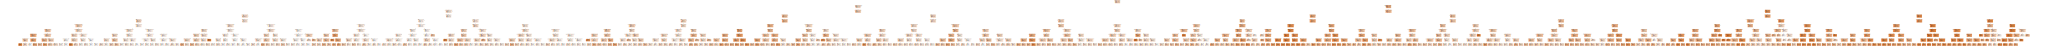

In [20]:
from sklearn.tree import export_graphviz
import graphviz
tree_str = export_graphviz(best_tree, feature_names=X_train.columns, filled=True)
graphviz.Source(tree_str)

Постройте графики зависимости коэффициента детерминации на трейне и кросс-валидации от значения максимальной глубины (кривые валидации). Используйте заданные ранее значения для данного гиперпараметра (остальные гиперпараметры оставьте по умолчанию, зафиксировав лишь `random_state` = 20). В функции cross_val_score так же в качестве параметра `scoring` укажите 'r2', а в качестве параметра `cv` укажите 5.

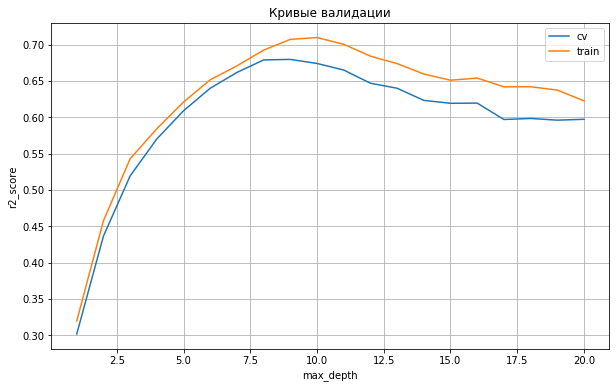

In [21]:
# Ваш код
train_scores = []
cv_scores = []
max_depth_values = np.arange(1,21)
for max_depth in max_depth_values:
    model = DecisionTreeRegressor(max_depth=max_depth, random_state=20)
    cv_score = cross_val_score(model, X_train, Y_train, scoring='r2', cv=5).mean()
    cv_scores.append(cv_score)
    model.fit(X_train, Y_train)
    train_scores.append(r2_score(Y_test, model.predict(X_test)))

plt.figure(figsize=(10, 6))
plt.plot(max_depth_values, cv_scores, label = 'cv')
plt.plot(max_depth_values, train_scores, label = 'train')
plt.title('Кривые валидации')
plt.grid()
plt.xlabel('max_depth')
plt.ylabel('r2_score')
plt.legend()
plt.show()

**<font color='red'>Вопрос 5.</font> Какие процессы наблюдаются на кривых валидации при изменени максимальной глубины от 10 до 12 и от 13 до 15 соответственно?**
- недообучение; недообучение
- недообучение; переобучение
- переобучение; недообучение
- переобучение; переобучение

## Случайный лес

Обучите случайный лес на обучающей выборке с параметрами по умолчанию (лишь зафиксируйте `random_state`=20) и оцените скор на тестовой. В качестве меткрики используйте коэффициент детерминации (функция r2_score).

In [24]:
# Ваш код
random_forest = RandomForestRegressor(random_state=20)
random_forest.fit(X_train, Y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=20, verbose=0, warm_start=False)

In [25]:
random_forest_score = round(r2_score(Y_test, random_forest.predict(X_test)),3)
print(random_forest_score)

0.812


Осуществите с помощью GridSearchCV поиск оптимальных значений максимальной глубины (диапазон для поиска: от 1 до 17 с шагом 2) и минимального числа объектов в листе (диапазон для поиска: от 1 до 21 с шагом 4). В качестве параметра `scoring` укажите 'r2', а в качестве параметра `cv` укажите 5 (обычная пятифолдовая кросс-валидация). Выведите данные оптимальные значения. Сохраните модель с получившимся значениями гиперпараметров и оцените скор на тестовой выборке. 

In [68]:
# Ваш код
params_grid = {'max_depth':list(i for i in range(1,18,2)), 
               'min_samples_leaf':list(i for i in range(1,22,4))}
random_gs = GridSearchCV(estimator=random_forest, param_grid=params_grid, scoring='r2', cv=5)
random_gs.fit(X_train, Y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=10, n_jobs=None,
                                             oob_score=False, random_state=20,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': [1, 3, 5, 7, 9, 11, 13, 

**<font color='red'>Вопрос 6.</font> На сколько улучшился скор на тесте после подбора гиперпараметров случайного леса на кросс-валидации? Ответ округлите до трех знаков после запятой.**

In [77]:
best_random_forest = random_gs.best_estimator_
print('Best parametres of random forest:',random_gs.best_params_)
print(best_random_forest)
best_random_forest.fit(X_train, Y_train)
best_random_forest_score = round(r2_score(Y_test, best_random_forest.predict(X_test)),3)

print('r2 score of random forest =', random_forest_score)
print('r2 score of best random forest =', best_random_forest_score)
print('Diference =', round(best_random_forest_score - random_forest_score,3))

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=17,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=5, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=20, verbose=0,
                      warm_start=False)
r2 score of random forest = 0.79
r2 score of best random forest = 0.793
Diference = 0.003


**<font color='red'>Вопрос 7.</font> Оцените важности признаков для случайного леса с лучшим значениями гиперпараметров. Расположите признаки в порядке убывания их важности.**
- MedInc, Latitude, Longitude, HouseAge, AveOccup, AveRooms, Population, AveBedrms
- Longitude, MedInc, Latitude, AveOccup, HouseAge, AveRooms, Population, AveBedrms
- MedInc, AveOccup, Longitude, Latitude, HouseAge, AveRooms, Population, AveBedrms
- Longitude, Latitude, MedInc, AveOccup, HouseAge, AveRooms, Population, AveBedrms

In [23]:
# Ваш код
tree_str = export_graphviz(best_random_forest, feature_names=X_train.columns, filled=True)
graphviz.Source(tree_str)

NameError: name 'best_random_forest' is not defined

Постройте кривые валидации при подборе максимальной глубины (остальные гиперпараметры оставьте по умолчанию, зафиксировав лишь `random_state` = 20). Используйте заданные ранее значения для данного гиперпараметра. В функции cross_val_score так же в качестве параметра `scoring` укажите 'r2', а в качестве параметра `cv` укажите 5.

In [ ]:
# Ваш код

**<font color='red'>Вопрос 8.</font> Взгляните на построенные кривые валидации. Что можно добиться в данной задаче, уменьшив максимальную глубину со значения 17? Выберите один, два или ноль правильных ответов.**
- небольшого прироста скора на кросс-валидации
- снижения разности скоров на тренировочной выборке и кросс-валидации при сохранении неплохого скора (> 0.70) на кросс-валидации

Постройте кривые валидации при подборе минимального числа объектов в листе (остальные гиперпараметры оставьте по умолчанию, зафиксировав лишь `random_state` = 20). Используйте заданные ранее значения для данного гиперпараметра. В функции cross_val_score так же в качестве параметра `scoring` укажите 'r2', а в качестве параметра `cv` укажите 5.

In [32]:
# Ваш код

**<font color='red'>Вопрос 9.</font> Взгляните на построенные кривые валидации. Что можно добиться в данной задаче, увеличив минимальное число объектов в листе со значения 1? Выберите один, два или ноль правильных ответов.**
- небольшого прироста скора на кросс-валидации
- снижения разности скоров на тренировочной выборке и кросс-валидации при сохранении неплохого скора (> 0.75) на кросс-валидации